In [129]:
import os
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights
from tqdm import tqdm
import matplotlib.pyplot as plt
from animal_dataset import AnimalCLEFDataset  # now importable

In [130]:
# =============================
# Configurations
# =============================
BATCH_SIZE = 32
NUM_WORKERS = 4
IMAGE_SIZE = 224
LR = 1e-4

epoch = 30
EPOCHS_CLP = epoch
EPOCHS_PLF = epoch

LAMBDA = 0.2
ALPHA_CL = .2
ALPHA_REC = 1.8

FORCE_TRAIN_RESTART = True

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT_DIR = './checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

root = '../animal-clef-2025_data'

# reproducibility
torch.manual_seed(42)

In [131]:
# Set device, Mac, GPU, or CPU
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("Using device:", DEVICE)

Using device: mps


In [132]:
"""
# =============================
# Dataset
# =============================
class AnimalCLEFDataset(Dataset):
    def __init__(self, root, split="database", transform=None):
        self.root = root.rstrip('/')
        meta = pd.read_csv(f"{self.root}/metadata.csv")
        sel = meta[meta['path'].str.contains(f"/{split}/")].reset_index(drop=True)
        if sel.empty:
            raise ValueError(f"No entries for split '{split}'")

        self.paths = sel['path'].tolist()
        self.image_ids = sel['image_id'].tolist()

        if split == 'database':
            #  Use individual identity,  
            ids = sel['identity'].astype(str)

            #  Build mapping from identity string → label index
            self.id2idx = {iid: i for i, iid in enumerate(sorted(ids.unique()))}

            #  Map each sample's identity to its label
            self.labels = ids.map(self.id2idx).tolist()

            # Safety check
            num_classes = len(self.id2idx)
            assert all(0 <= label < num_classes for label in self.labels), "Invalid labels found"
        else:
            self.labels = [-1] * len(sel)

        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(f"{self.root}/{self.paths[i]}").convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[i]
""";

In [133]:
# =============================
# MAE Encoder + Projection Head + Decoder
# =============================
class MAEFramework(nn.Module):
    def __init__(self,
                 embed_dim: int = 768,
                 proj_dim: int = 256,
                 decoder_dim: int = 256,
                 layer_indices: list[int] = [3, 6, 9]):
        super().__init__()
        self.embed_dim = embed_dim
        # 1) Backbone ViT
        self.encoder = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        self.encoder.head = nn.Identity()
        self.layer_indices = set(layer_indices)

        # 3) Projection head
        self.proj_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(inplace=True),
            nn.Linear(embed_dim, proj_dim),
        )
        # 4) Decoder
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, decoder_dim),
            nn.ReLU(inplace=True),
            nn.Linear(decoder_dim, 3 * IMAGE_SIZE * IMAGE_SIZE),
        )

    def forward(self, x: torch.Tensor, return_feats: bool = False):
        B = x.size(0)
        # patch embed
        x_p = self.encoder.conv_proj(x)
        x_p = x_p.flatten(2).transpose(1, 2)
        cls_tok = self.encoder.class_token.expand(B, -1, -1)
        tokens = torch.cat([cls_tok, x_p], dim=1)
        tokens = tokens + self.encoder.encoder.pos_embedding

        feats = []
        for idx, block in enumerate(self.encoder.encoder.layers):
            tokens = block(tokens)
            if idx in self.layer_indices:
                feats.append(tokens.clone())

        cls_feat = self.encoder.encoder.ln(tokens[:, 0])
        proj = self.proj_head(cls_feat)
        rec = self.decoder(cls_feat).view(B, 3, IMAGE_SIZE, IMAGE_SIZE)
        rec_loss = F.mse_loss(rec, x, reduction='none').mean([1, 2, 3])

        if return_feats:
            return cls_feat, proj, rec_loss, rec, feats
        return proj, rec_loss, rec


In [134]:
# =============================
# Losses
# =============================
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temp = temperature

    def forward(self, p1, p2, labels=None):
        # NT-Xent instance-level contrastive loss
        z = torch.cat([p1, p2], dim=0)
        z = F.normalize(z, dim=1)
        N = p1.size(0)
        sim = torch.matmul(z, z.T) / self.temp
        mask = torch.eye(2*N, device=sim.device).bool()
        sim.masked_fill_(mask, -9e15)
        idx = torch.arange(N, device=sim.device)
        targets = torch.cat([idx + N, idx])
        return F.cross_entropy(sim, targets)

class ProtoLoss(nn.Module):
    def forward(self, feats, prototypes, labels):
        dist = torch.cdist(feats, prototypes)
        return F.cross_entropy(-dist, labels)

In [135]:
# =============================
# Utilities
# =============================
def compute_layer_distances(bef_feats, aft_feats, temperature=0.5):
    total = []  # Initialize as a list to store distances per layer
    for b, a in zip(bef_feats, aft_feats):
        b_f, a_f = b.flatten(1), a.flatten(1)
        eu = F.pairwise_distance(b_f, a_f)
        cos = 1 - F.cosine_similarity(b_f, a_f, dim=1)
        score = eu + temperature * cos  # this score is already (B,)
        total.append(score)  # Add the current batch's score to the list
    return torch.stack(total, dim=0).mean(dim=0)  # Stack and compute mean along dim=0

def calculate_unknown_score(feat_bef, feat_aft, feat_vec, prototypes, lamda=1.0):
    # 1. Compute multilayer feature distance (s_total)
    s_total = compute_layer_distances(feat_bef, feat_aft, temperature=0.5)  # Can keep temp fixed or expose as param

    # 2. Compute max prototype similarity (s_prototypes)
    fv_n = F.normalize(feat_vec, dim=1)  # (B, D)
    p_n = F.normalize(prototypes, dim=1)  # (C, D)
    sim = torch.matmul(fv_n, p_n.T)  # (B, C)
    s_proto, _ = sim.max(dim=1)  # (B,)

    # 3. Final score using lambda
    score = s_proto - lamda * s_total

    return score  # (B,)

In [136]:
def train_CLP(model, loader, epochs, lr, ckpt, alpha_cl=1.0, alpha_rec=1.0, force_restart = False):
    cl_hist, rec_hist, tot_hist = [], [], []
    path = os.path.join(CHECKPOINT_DIR, ckpt)
    opt  = torch.optim.Adam(model.parameters(), lr=lr)
    start = 0

    if os.path.exists(path) and force_restart:
        print(f"Checkpoint {path} exists. Restarting training.")
        os.remove(path)

    # load checkpoint (stripping "module." if needed) …
    if os.path.exists(path):
        ck     = torch.load(path, map_location=DEVICE)
        raw_sd = ck['model']
        sd     = {k.replace("module.", ""): v for k, v in raw_sd.items()}
        model.load_state_dict(sd)
        opt.load_state_dict(ck['opt'])
        start = ck['ep'] + 1

    scl = SupConLoss()
    model.to(DEVICE)

    for ep in range(start, epochs):
        model.train()

        # reset accumulators each epoch
        total_cl, total_rec, total = 0.0, 0.0, 0.0

        for x, y in tqdm(loader, desc=f"CLP Ep{ep+1}"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            x1 = x + 0.05 * torch.randn_like(x)
            x2 = x + 0.05 * torch.randn_like(x)

            _, p1, r1_loss, _, _ = model(x1, return_feats=True)
            _, p2, r2_loss, _, _ = model(x2, return_feats=True)

            l_cl  = scl(p1, p2)
            l_rec = r1_loss.mean() + r2_loss.mean()
            loss  = alpha_cl * l_cl + alpha_rec * l_rec

            opt.zero_grad()
            loss.backward()
            opt.step()

            total      += loss.item()
            total_cl   += l_cl.item()
            total_rec  += l_rec.item()

        # save checkpoint
        torch.save({
            'model': model.module.state_dict() if isinstance(model, nn.DataParallel)
                                                 else model.state_dict(),
            'opt':   opt.state_dict(),
            'ep':    ep
        }, path)

        # compute per-epoch averages
        avg_cl  = total_cl  / len(loader)
        avg_rec = total_rec / len(loader)
        avg_tot = total  / len(loader)

        # record histories
        cl_hist.append(avg_cl)
        rec_hist.append(avg_rec)
        tot_hist.append(avg_tot)

        print(f"CLP Epoch {ep+1}: total={avg_tot:.4f}, cl={avg_cl:.4f}, rec={avg_rec:.4f}")

    return model, cl_hist, rec_hist, tot_hist


In [137]:
"""def train_CLP(model, loader, epochs, lr, ckpt, alpha_cl=1.0, alpha_rec=1.0):
    
    path = os.path.join(CHECKPOINT_DIR, ckpt)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    start = 0

    # --- load checkpoint if it exists, stripping "module." if necessary
    if os.path.exists(path):
        ck = torch.load(path, map_location=DEVICE)
        raw_sd = ck['model']
        # strip DataParallel "module." prefix
        sd = {k.replace("module.", ""): v for k, v in raw_sd.items()}
        model.load_state_dict(sd)
        opt.load_state_dict(ck['opt'])
        start = ck['ep'] + 1
    # ---------------------------------------------------------------

    scl = SupConLoss()
    model.to(DEVICE)

    for ep in range(start, epochs):
        model.train()
        total = 0.0
        for x, y in tqdm(loader, desc=f"CLP Ep{ep+1}"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            x1 = x + 0.05 * torch.randn_like(x)
            x2 = x + 0.05 * torch.randn_like(x)
            f1, p1, r1_loss, r1, _ = model(x1, return_feats=True)
            f2, p2, r2_loss, r2, _ = model(x2, return_feats=True)
            l_cl  = scl(p1, p2)
            l_rec = r1_loss.mean() + r2_loss.mean()
            loss  = alpha_cl * l_cl + alpha_rec * l_rec
            opt.zero_grad()
            loss.backward()
            opt.step()
            total += loss.item()

        torch.save({
            'model': model.state_dict() if not isinstance(model, nn.DataParallel)
                              else model.module.state_dict(),
            'opt':   opt.state_dict(),
            'ep':    ep
        }, path)
        print(f"CLP Epoch {ep+1}: {total/len(loader):.4f}")
        """;


In [138]:
def train_PLF(model, loader, epochs, lr, ckpt, num_classes, encoder_pre):
    path = os.path.join(CHECKPOINT_DIR, ckpt)
    # unwrap if DataParallel
    base_model = model.module if isinstance(model, nn.DataParallel) else model
    embed_dim   = base_model.embed_dim

    proto_tensor = torch.randn(num_classes, embed_dim, device=DEVICE)
    proto = nn.Parameter(proto_tensor, requires_grad=True)
    opt   = torch.optim.Adam(list(model.parameters()) + [proto], lr=lr)
    start = 0

    # --- load checkpoint if it exists, stripping "module." if necessary
    if os.path.exists(path):
        ck = torch.load(path, map_location=DEVICE)
        raw_sd = ck['model']
        sd = {k.replace("module.", ""): v for k, v in raw_sd.items()}
        model.load_state_dict(sd)
        proto.data = ck['proto']
        opt.load_state_dict(ck['opt'])
        start = ck['ep'] + 1
    # ---------------------------------------------------------------

    ploss = ProtoLoss()
    model.to(DEVICE)

    for ep in range(start, epochs):
        model.train()
        total = 0.0
        for x, y in tqdm(loader, desc=f"PLF Ep{ep+1}"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            feats, _, _, _, _ = model(x, return_feats=True)
            loss = ploss(feats, proto, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total += loss.item()

        torch.save({
            'model': model.state_dict() if not isinstance(model, nn.DataParallel)
                              else model.module.state_dict(),
            'proto': proto.data,
            'opt':   opt.state_dict(),
            'ep':    ep
        }, path)
        print(f"PLF Epoch {ep+1}: {total/len(loader):.4f}")

    return proto


In [139]:
"""
# =============================
# Training: CLP
# =============================
def train_CLP(model, loader, epochs, lr, ckpt, alpha_cl=1.0, alpha_rec=1.0):
    path = os.path.join(CHECKPOINT_DIR, ckpt)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    start = 0
    if os.path.exists(path):
        ck = torch.load(path)
        model.load_state_dict(ck['model'])
        opt.load_state_dict(ck['opt'])
        start = ck['ep'] + 1
    scl = SupConLoss()
    model.to(DEVICE)

    for ep in range(start, epochs):
        model.train()
        total = 0.0
        for x, y in tqdm(loader, desc=f"CLP Ep{ep+1}"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            x1 = x + 0.05 * torch.randn_like(x)
            x2 = x + 0.05 * torch.randn_like(x)
            f1, p1, r1_loss, r1, _ = model(x1, return_feats=True)
            f2, p2, r2_loss, r2, _ = model(x2, return_feats=True)
            l_cl = scl(p1, p2)
            l_rec = r1_loss.mean() + r2_loss.mean()
            loss = alpha_cl * l_cl + alpha_rec * l_rec
            opt.zero_grad()
            loss.backward()
            opt.step()
            total += loss.item()
        torch.save({'model': model.state_dict(), 'opt': opt.state_dict(), 'ep': ep}, path)
        print(f"CLP Epoch {ep+1}: {total/len(loader):.4f}")


# =============================
# Training: PLF
# =============================
def train_PLF(model, loader, epochs, lr, ckpt, num_classes, encoder_pre):
    path = os.path.join(CHECKPOINT_DIR, ckpt)
    # unwrap if DataParallel
    base_model = model.module if isinstance(model, nn.DataParallel) else model
    embed_dim = base_model.embed_dim
    proto_tensor = torch.randn(num_classes, embed_dim, device=DEVICE)
    proto = nn.Parameter(proto_tensor, requires_grad=True)
    opt = torch.optim.Adam(list(model.parameters()) + [proto], lr=lr)
    start = 0
    if os.path.exists(path):
        ck = torch.load(path)
        model.load_state_dict(ck['model'])
        proto.data = ck['proto']
        opt.load_state_dict(ck['opt'])
        start = ck['ep'] + 1
    ploss = ProtoLoss()
    model.to(DEVICE)

    for ep in range(start, epochs):
        model.train()
        total = 0.0
        for x, y in tqdm(loader, desc=f"PLF Ep{ep+1}"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            feats, _, _, _, _ = model(x, return_feats=True)
            loss = ploss(feats, proto, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total += loss.item()
        torch.save({'model': model.state_dict(), 'proto': proto.data, 'opt': opt.state_dict(), 'ep': ep}, path)
        print(f"PLF Epoch {ep+1}: {total/len(loader):.4f}")
    return proto
""";
    
# =============================
# Inference
# =============================

@torch.no_grad()
def inference(enc_pre, model, proto, loader, threshold, lamda=1.0):
    enc_pre.eval()
    model.eval()
    preds = []

    for x, _ in tqdm(loader, desc="Infer"):
        x = x.to(DEVICE)
        enc_pre = enc_pre.to(DEVICE)
        model = model.to(DEVICE)

        _, _, _, _, bef_feats = enc_pre(x, return_feats=True)
        feat, _, _, _, aft_feats = model(x, return_feats=True)

        # 1. Calculate unknown score
        scores = calculate_unknown_score(bef_feats, aft_feats, feat, proto, lamda = lamda)  # shape: (B,)

        # 2. Predict the most similar known class
        idx = torch.argmax(torch.matmul(F.normalize(feat, dim=1), F.normalize(proto, dim=1).T), dim=1)  # (B,)

        # 3. Threshold to filter unknowns
        known = scores > threshold
        pred = idx.clone()
        pred[~known] = -1  # mark unknowns

        preds.append(pred.cpu())

    return torch.cat(preds, dim=0)

In [140]:
# =============================
# Submission
# =============================
def generate_submission(root, preds, db_ds):
    sub = pd.read_csv(f"{root}/sample_submission.csv")
    meta = pd.read_csv(f"{root}/metadata.csv")
    q = meta[meta['path'].str.contains('/query/')].reset_index(drop=True)
    q['pred_idx'] = preds.numpy()

    # Step 1: Print raw predicted indices
    print("\nRaw predicted indices (pred_idx):")
    print(q[['image_id', 'pred_idx']].head(10))

    # Step 2: Index to identity mapping
    idx2id = {v: k for k, v in db_ds.id2idx.items()}
    q['prediction'] = q['pred_idx'].apply(lambda i: 'new_individual' if i < 0 else idx2id.get(int(i), f"unknown_{i}"))

    # Step 3: Print mapped predictions
    print("\nMapped predictions (after idx2id):")
    print(q[['image_id', 'prediction']].head(10))

    # drop the original metadata identity so we don't end up with two columns
    q = q.drop(columns=['identity'])

    # rename 'prediction' → 'identity' so the output column is called identity
    q = q.rename(columns={'prediction':'identity'})

    # now merge on image_id and keep the 'identity' column
    out = sub[['image_id']].merge(q[['image_id','identity']], on='image_id')

    #out = sub[['image_id']].merge(q[['image_id', 'identity']], on='image_id')
    #out = sub[['image_id']].merge(q[['image_id','prediction']], on='image_id')


    timestamp = time.strftime("%Y%m%d-%H%M%S")
    save_path = f'submission_{timestamp}.csv'
    out.to_csv(save_path, index=False)

    return save_path

Checkpoint ./checkpoints/clp.pth exists. Restarting training.


CLP Ep1:   0%|          | 0/409 [00:00<?, ?it/s]/Users/matthewjones2/anaconda3/envs/574_animal_clef_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
CLP Ep1: 100%|██████████| 409/409 [08:26<00:00,  1.24s/it]


CLP Epoch 1: total=0.6409, cl=2.3755, rec=0.0921


CLP Ep2: 100%|██████████| 409/409 [08:32<00:00,  1.25s/it]


CLP Epoch 2: total=0.5667, cl=2.3089, rec=0.0583


CLP Ep3: 100%|██████████| 409/409 [08:29<00:00,  1.25s/it]


CLP Epoch 3: total=0.5517, cl=2.2947, rec=0.0516


CLP Ep4: 100%|██████████| 409/409 [08:34<00:00,  1.26s/it]


CLP Epoch 4: total=0.5411, cl=2.2879, rec=0.0464


CLP Ep5: 100%|██████████| 409/409 [08:35<00:00,  1.26s/it]


CLP Epoch 5: total=0.5339, cl=2.2811, rec=0.0432


CLP Ep6: 100%|██████████| 409/409 [08:28<00:00,  1.24s/it]


CLP Epoch 6: total=0.5292, cl=2.2765, rec=0.0411


CLP Ep7: 100%|██████████| 409/409 [08:33<00:00,  1.25s/it]


CLP Epoch 7: total=0.5268, cl=2.2739, rec=0.0400


CLP Ep8: 100%|██████████| 409/409 [08:31<00:00,  1.25s/it]


CLP Epoch 8: total=0.5249, cl=2.2732, rec=0.0390


CLP Ep9: 100%|██████████| 409/409 [08:29<00:00,  1.25s/it]


CLP Epoch 9: total=0.5223, cl=2.2712, rec=0.0378


CLP Ep10: 100%|██████████| 409/409 [08:28<00:00,  1.24s/it]


CLP Epoch 10: total=0.5207, cl=2.2711, rec=0.0369


CLP Ep11: 100%|██████████| 409/409 [08:27<00:00,  1.24s/it]


CLP Epoch 11: total=0.5195, cl=2.2708, rec=0.0363


CLP Ep12: 100%|██████████| 409/409 [08:27<00:00,  1.24s/it]


CLP Epoch 12: total=0.5174, cl=2.2685, rec=0.0354


CLP Ep13: 100%|██████████| 409/409 [08:27<00:00,  1.24s/it]


CLP Epoch 13: total=0.5157, cl=2.2666, rec=0.0347


CLP Ep14: 100%|██████████| 409/409 [08:26<00:00,  1.24s/it]


CLP Epoch 14: total=0.5147, cl=2.2675, rec=0.0340


CLP Ep15: 100%|██████████| 409/409 [08:26<00:00,  1.24s/it]


CLP Epoch 15: total=0.5135, cl=2.2665, rec=0.0335


CLP Ep16: 100%|██████████| 409/409 [08:26<00:00,  1.24s/it]


CLP Epoch 16: total=0.5126, cl=2.2661, rec=0.0330


CLP Ep17: 100%|██████████| 409/409 [08:20<00:00,  1.22s/it]


CLP Epoch 17: total=0.5116, cl=2.2650, rec=0.0326


CLP Ep18: 100%|██████████| 409/409 [08:21<00:00,  1.23s/it]


CLP Epoch 18: total=0.5106, cl=2.2639, rec=0.0321


CLP Ep19: 100%|██████████| 409/409 [08:21<00:00,  1.23s/it]


CLP Epoch 19: total=0.5098, cl=2.2636, rec=0.0317


CLP Ep20: 100%|██████████| 409/409 [08:22<00:00,  1.23s/it]


CLP Epoch 20: total=0.5091, cl=2.2638, rec=0.0313


CLP Ep21: 100%|██████████| 409/409 [08:26<00:00,  1.24s/it]


CLP Epoch 21: total=0.5086, cl=2.2635, rec=0.0311


CLP Ep22: 100%|██████████| 409/409 [08:27<00:00,  1.24s/it]


CLP Epoch 22: total=0.5076, cl=2.2624, rec=0.0306


CLP Ep23: 100%|██████████| 409/409 [08:25<00:00,  1.24s/it]


CLP Epoch 23: total=0.5072, cl=2.2631, rec=0.0303


CLP Ep24: 100%|██████████| 409/409 [08:19<00:00,  1.22s/it]


CLP Epoch 24: total=0.5061, cl=2.2607, rec=0.0300


CLP Ep25: 100%|██████████| 409/409 [08:20<00:00,  1.22s/it]


CLP Epoch 25: total=0.5057, cl=2.2617, rec=0.0296


CLP Ep26: 100%|██████████| 409/409 [08:22<00:00,  1.23s/it]


CLP Epoch 26: total=0.5051, cl=2.2615, rec=0.0293


CLP Ep27: 100%|██████████| 409/409 [08:23<00:00,  1.23s/it]


CLP Epoch 27: total=0.5043, cl=2.2605, rec=0.0290


CLP Ep28: 100%|██████████| 409/409 [08:22<00:00,  1.23s/it]


CLP Epoch 28: total=0.5039, cl=2.2604, rec=0.0288


CLP Ep29: 100%|██████████| 409/409 [08:22<00:00,  1.23s/it]


CLP Epoch 29: total=0.5033, cl=2.2600, rec=0.0285


CLP Ep30: 100%|██████████| 409/409 [08:22<00:00,  1.23s/it]


CLP Epoch 30: total=0.5030, cl=2.2602, rec=0.0283


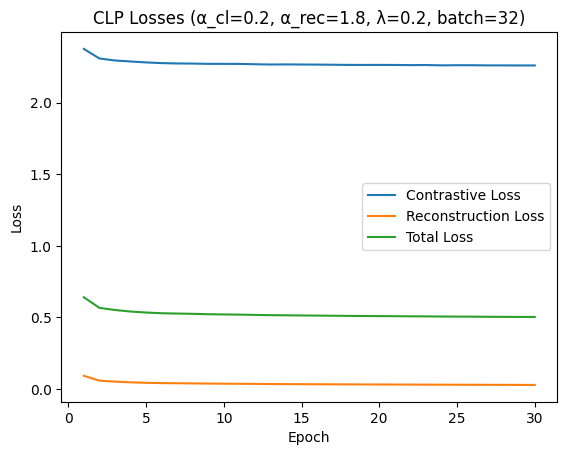

Prototype shape: torch.Size([1102, 768])
Number of unique classes: 1102


Infer: 100%|██████████| 67/67 [00:48<00:00,  1.39it/s]

Saving submission…

Raw predicted indices (pred_idx):
   image_id  pred_idx
0         3        -1
1         5        24
2        12        -1
3        13        -1
4        18        -1
5        19        -1
6        27        -1
7        33        -1
8        36        -1
9        45        -1

Mapped predictions (after idx2id):
   image_id          prediction
0         3      new_individual
1         5  LynxID2025_lynx_32
2        12      new_individual
3        13      new_individual
4        18      new_individual
5        19      new_individual
6        27      new_individual
7        33      new_individual
8        36      new_individual
9        45      new_individual


In [141]:
# =============================
# Main Workflow
# =============================
def main():
    #root = '/kaggle/input/animal-clef-2025'
    tf = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor()
    ])
    #idx2id = {v: k for k, v in db_ds.id2idx.items()}

    db_ds = AnimalCLEFDataset(root, 'database', transform=tf)
    
    #print("Example metadata path[0]:", db_ds.paths[0])
    #print("Looking for file at:", os.path.join(db_ds.root, db_ds.paths[0]))
    #print("Exists on disk?", os.path.exists(os.path.join(db_ds.root, db_ds.paths[0])))
    
    db_loader = DataLoader(db_ds, batch_size = BATCH_SIZE, shuffle=True,
                           num_workers=NUM_WORKERS, pin_memory=True)
    query_ds = AnimalCLEFDataset(root, 'query', transform=tf)
    q_loader = DataLoader(query_ds, batch_size = BATCH_SIZE, shuffle=False,
                           num_workers=NUM_WORKERS, pin_memory=True)

    clp_model = MAEFramework()
    plf_model = MAEFramework()

    # pick your device
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        DEVICE = torch.device("mps")
    elif torch.cuda.is_available():
        DEVICE = torch.device("cuda")
    else:
        DEVICE = torch.device("cpu")

    # decide which GPUs to wrap
    cuda_gpus = torch.cuda.device_count()
    if DEVICE.type == "cuda" and cuda_gpus > 1:
        device_ids = list(range(cuda_gpus))  # e.g. [0,1,…]
        clp_model = nn.DataParallel(clp_model,  device_ids=device_ids).to(DEVICE)
        plf_model = nn.DataParallel(plf_model,  device_ids=device_ids).to(DEVICE)
    else:
        # single‐device: MPS, single CUDA, or CPU
        clp_model = clp_model.to(DEVICE)
        plf_model = plf_model.to(DEVICE)

    # now training and inference will work on either MPS or CUDA
    #train_CLP(clp_model, db_loader, EPOCHS_CLP, LR,  'clp.pth', alpha_cl = ALPHA_CL, alpha_rec = ALPHA_REC)
    
    clp_model, cl_hist, rec_hist, tot_hist = train_CLP(
        clp_model, db_loader, EPOCHS_CLP, LR, 'clp.pth',
        alpha_cl=ALPHA_CL, alpha_rec=ALPHA_REC, force_restart=FORCE_TRAIN_RESTART)
    
    epochs = list(range(1, len(cl_hist)+1))
    plt.plot(epochs, cl_hist, label='Contrastive Loss')
    plt.plot(epochs, rec_hist, label='Reconstruction Loss')
    plt.plot(epochs, tot_hist, label='Total Loss')

    plt.title(f'CLP Losses (α_cl={ALPHA_CL}, α_rec={ALPHA_REC}, λ={LAMBDA}, batch={BATCH_SIZE})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    prototype = train_PLF(plf_model, db_loader, EPOCHS_PLF, LR,
                          'plf.pth', len(db_ds.id2idx), clp_model)
    

    
    print("Prototype shape:", prototype.shape)
    print("Number of unique classes:", len(db_ds.id2idx))

    # Plot the score distribution before estimating threshold
    #plot_score_distribution(clp_model, plf_model, prototype, db_loader)

    # Estimate threshold from database distribution
    dists = []
    with torch.no_grad():
        for x, _ in DataLoader(db_ds, batch_size = BATCH_SIZE, shuffle=False,
                               num_workers=NUM_WORKERS, pin_memory=True):
            x = x.to(DEVICE)
            feat, _, _, _, aft_feats = plf_model(x, return_feats=True)
            _, _, _, _, bef_feats = clp_model(x, return_feats=True)
            scores = calculate_unknown_score(bef_feats, aft_feats, feat, prototype, lamda = LAMBDA)
            dists.extend(scores.cpu().tolist())


    threshold = torch.quantile(torch.tensor(dists), 0.95).item()


    # Inference on query set
    with torch.no_grad():
        #lamda = 0.2 # or any value you want to test
        preds = inference(clp_model, plf_model, prototype, q_loader, threshold, lamda = LAMBDA)


    print("Saving submission…")
    generate_submission(root, preds, db_ds)

if __name__ == '__main__':
    main()


In [142]:
#preds = inference(clp_model, plf_model, prototype, q_loader, threshold, lamda=lamda)
#print("Saving submission…")
#generate_submission(root, preds, db_ds)